<center><h1>Lab 2 - Time series analysis</h1></center>
<center><h2>Carolina Pilar Diaz - Juan Pablo Fabro</h2></center>
<br>

En este lab aplicaremos métodos de suavizado exponencial para pronosticar datos estacionales de la demanda energ&eacute;tica en Python

<a class="buttom" href=">#Data:-NSW-retail-turnover">Data: Demanda energ&eacute;tica mes por mes brindada por CAMMESA (Compañ&iacute;a administradora del mercado mayorista el&eacute;ctrico)</a> <br>
<a class="buttom" href="#Time-series-decomposition">Time series decomposition</a> <br>
<a class="buttom" href="#Trend-corrected-exponential-Smoothing">Trend corrected exponential smoothing</a> <br>
<a class="buttom" href="#Hold-Exponential-Smoothing">Holt-Winters smoothing</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>


In [44]:
# Importacion de paquetes
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [45]:
# Plot seteos
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Demanda Energ&eacute;tica

En este laboratorio trabajaremos con series de tiempo de la demanda energ&eacute;tica brindada por CAMMESA. 
Primero cargamos los datos.

In [47]:
data = pd.read_csv("./datasets/demanda.csv", index_col='TIPO', parse_dates=True, dayfirst=True)
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


#### Para el an&aacute;lisis vamos a tener en cuenta el consumo total, que es la suma de los consumos energ&eacute;ticos de los clientes residenciales, comercios e industrias

In [ ]:
y = data['TOTAL'].copy() # Month period series
y.index = y.index.to_period(freq='M')

ts = data['TOTAL'] # Day indexed series

In [51]:
# Vemos los primeros 5 datos de la serie indexada por mes
y.head()

TIPO
2013-01    1.113412e+07
2013-02    9.834160e+06
2013-03    9.756129e+06
2013-04    9.307334e+06
2013-05    1.023283e+07
Freq: M, Name: TOTAL, dtype: float64

In [52]:
# Vemos los primeros 5 datos de la serie indexada por dia
ts.head()

TIPO
2013-01-01    1.113412e+07
2013-02-01    9.834160e+06
2013-03-01    9.756129e+06
2013-04-01    9.307334e+06
2013-05-01    1.023283e+07
Name: TOTAL, dtype: float64

In [61]:
# Vemos una descripcion de los datos
data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Residencial,79.0,4551935.29,654164.93,3239380.70,3990580.45,4470715.12,5092450.46,6193110.21
Comercial,79.0,3113096.42,206829.98,2809183.13,2948084.14,3070853.24,3270751.91,3606989.07
Industrial/Comercial Grande,79.0,3187977.02,124659.74,2897618.67,3109179.19,3199317.20,3275571.56,3460879.97
TOTAL,79.0,10853008.74,816874.81,9307334.16,10223259.40,10706955.32,11476364.98,12607552.72


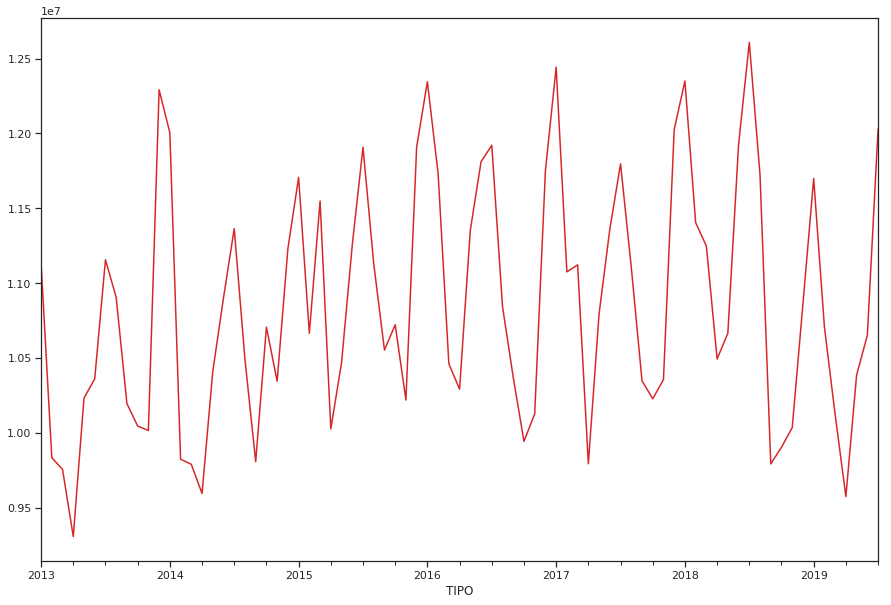

In [62]:
y.plot(color=red);

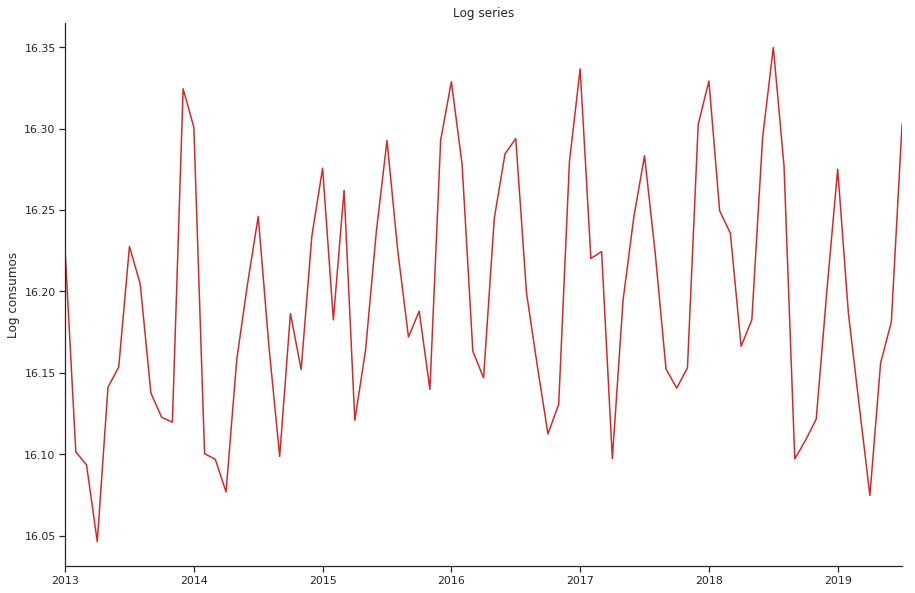

In [63]:
fig, ax= plt.subplots();
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log consumos')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Time series decomposition

We use the X-13 ARIMA-SEATS method for time series decomposition. The X-13 method is a state-of-art time series decomposition approach developed and provided by the [US Census Bureau](https://www.census.gov/srd/www/x13as/) as external software. You need to make the X-13 software available to Python by downloading it from the link and extracting the compressed folder to your computer. The <TT>statsmodels</TT> library has a function that interfaces with this software, and the easiest way to get it to work is to copy the <TT>x13as</TT> executable to the same folder as your notebook.  

The X-13 is the current version of the X-12-ARIMA method described in the [textbook](https://www.otexts.org/fpp/6/4). The only limitation is that the X-13 software makes calendar effect adjustments based on the US calendar by default, though it is possible to reconfigure it to other calendars. Refer to the [ABS](http://abs.gov.au/websitedbs/d3310114.nsf/4a256353001af3ed4b2562bb00121564/c890aa8e65957397ca256ce10018c9d8) for the seasonal adjustment standards in Australia.  

In [64]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='./x13asall_V1.1_B39')

/home/juan/anaconda3/envs/diplodatos/lib/python3.6/site-packages/statsmodels/tsa/x13.py:182: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/home/juan/anaconda3/envs/diplodatos/lib/python3.6/site-packages/statsmodels/tsa/x13.py:192: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  out = read_table(StringIO(x), skiprows=2, header=None)


You can use the <TT>dir</TT> method to check the available output. 

In [65]:
[attr for attr in dir(decomposition) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

Por ejemplo, para recuperar y graficar el componente ajustado estacionalmente, hacemos lo siguiente:

In [66]:
decomposition.seasadj.tail()

TIPO
2019-03-01    1.025205e+07
2019-04-01    1.045484e+07
2019-05-01    1.042364e+07
2019-06-01    1.021774e+07
2019-07-01    1.089532e+07
Name: seasadj, dtype: float64

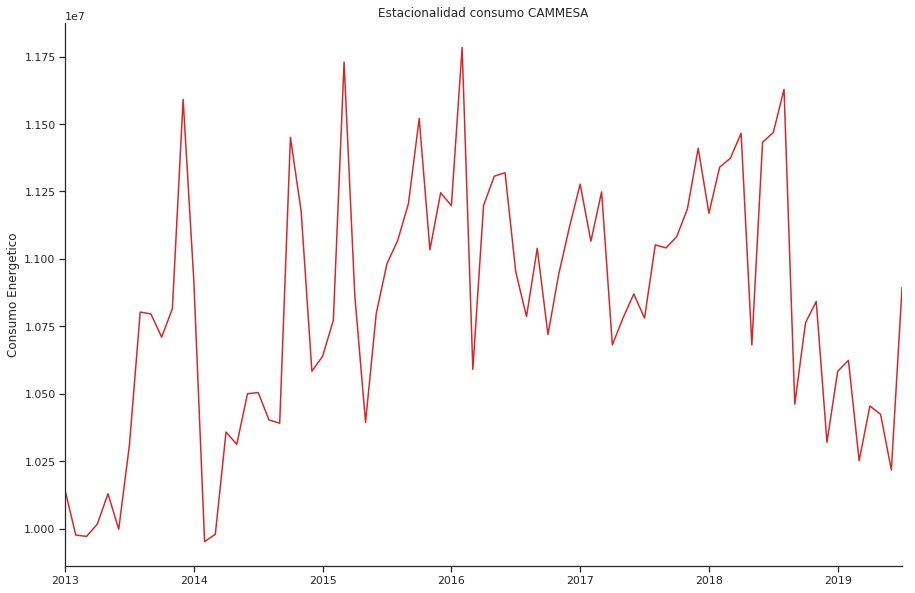

In [71]:
fig, ax= plt.subplots();
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Consumo Energetico')
ax.set_title('Estacionalidad consumo CAMMESA')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [ ]:
Si queremos hacer lo mismo pero esta vez para obtener y graficar el componente de tendencia:

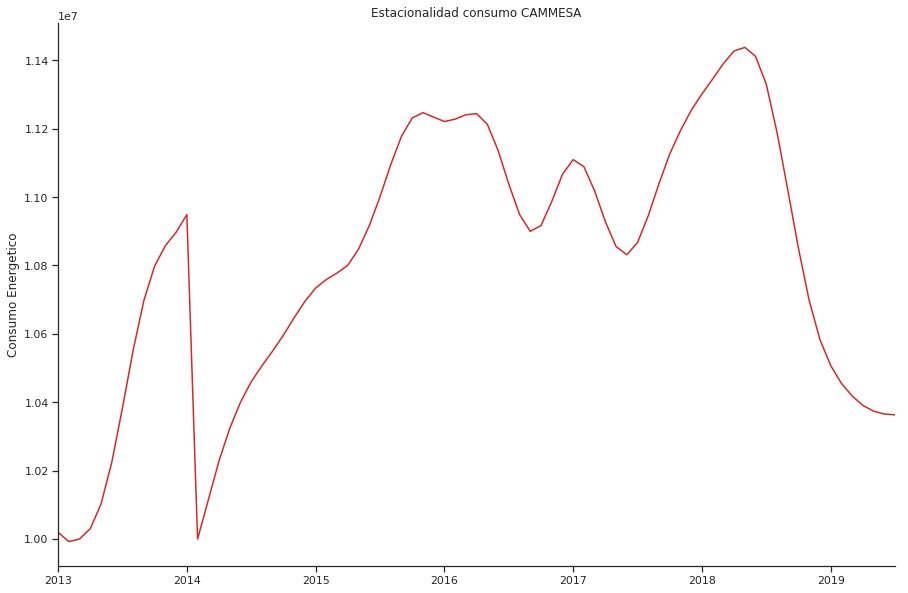

In [72]:
fig, ax= plt.subplots();
decomposition.trend.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Consumo Energetico')
ax.set_title('Estacionalidad consumo CAMMESA')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

El módulo <TT>plotting</TT> tiene una función que sirve para graficas todos los componentes

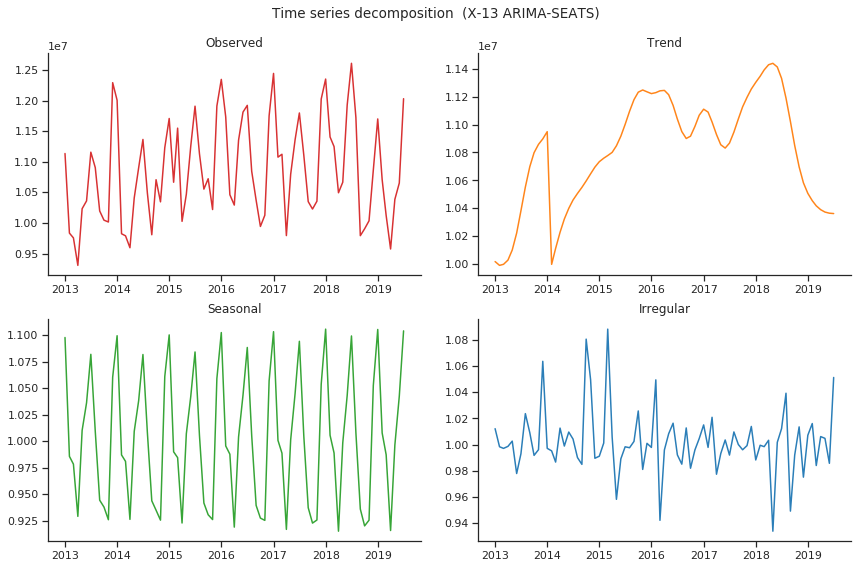

In [73]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

El software X-13-ARIMA genera un análisis muy detallado de la serie temporal, que se almacena en el atributo <TT>results</TT>. Podemos verlo con el comando print (decomposition.results), pero debido a la longitud, es recomendable guardarlo en un archivo de texto y abrirlo en otro lugar. A modo de ejemplo:

In [74]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

En caso de que no se pueda trabajar con el software de descomposición X13, hay una descomposición más básica disponible de la siguiente manera:

In [75]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

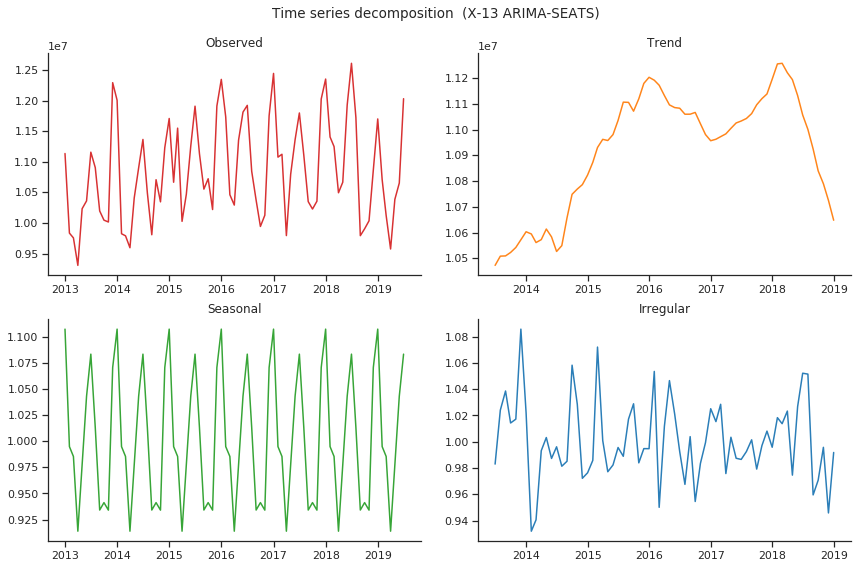

In [76]:
from plotting import plot_components_basic
plot_components_basic(basic_decomposition);

## Holt-winters exponential smoothing

Probamos con diferentes par&aacute;metros y obtenemos el error cuadr&aacute;tico medio en cada caso

In [101]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [102]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [103]:
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               471015.022


In [89]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               373386.184


In [90]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, 
                                       seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               373992.563


In [104]:
mhw_additive=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, 
                                       seasonal='additive', seasonal_periods=12).fit()
hw_summary(mhw_additive)

 In-sample fit:
 RMSE               437965.887


In [105]:
mhw_multiplicative=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, 
                                       seasonal='multiplicative', seasonal_periods=12).fit()
hw_summary(mhw_multiplicative)

 In-sample fit:
 RMSE               373992.563


Como podemos ver en base a los errores cuadr&aacute;ticos medios obtenidos (RMSE), la serie suavizada basada en el método multiplicativo sigue m&aacute;s de cerca la serie original que con otros par&aacute;metros ya que obtiene el valor de RMSE m&aacute;s bajo (373386.184)

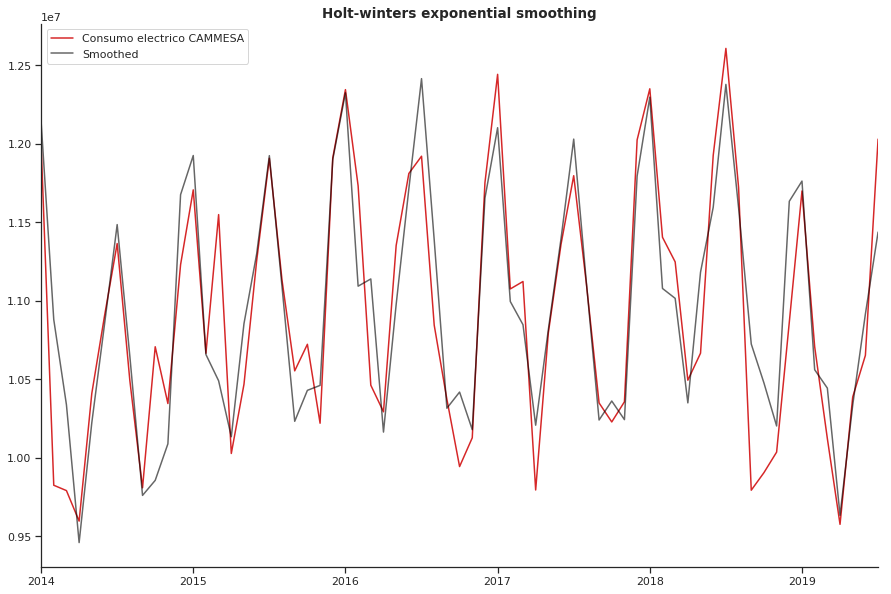

In [107]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots();#figsize=(9,6))

y['2014':].plot(color='#D62728', label='Consumo electrico CAMMESA')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

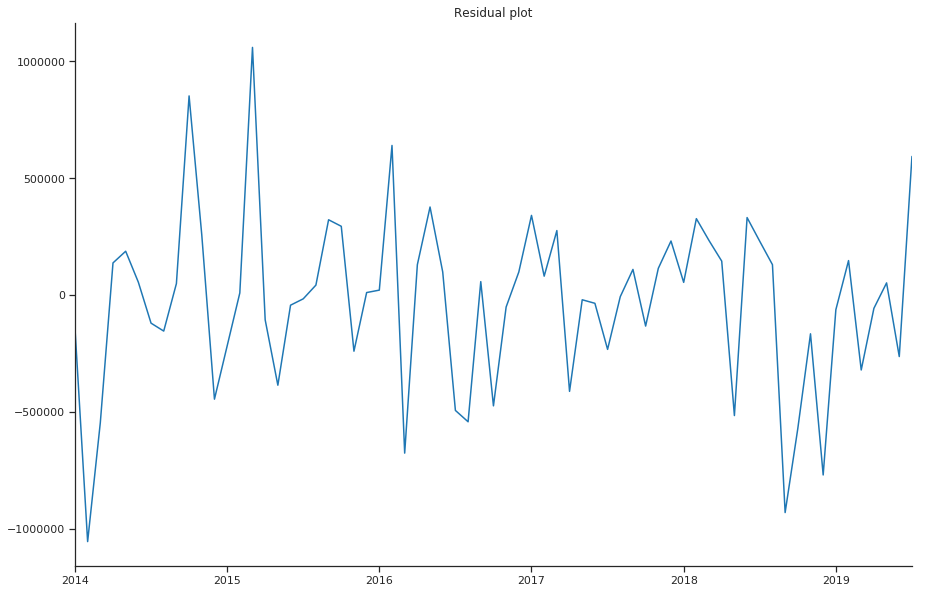

In [108]:
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

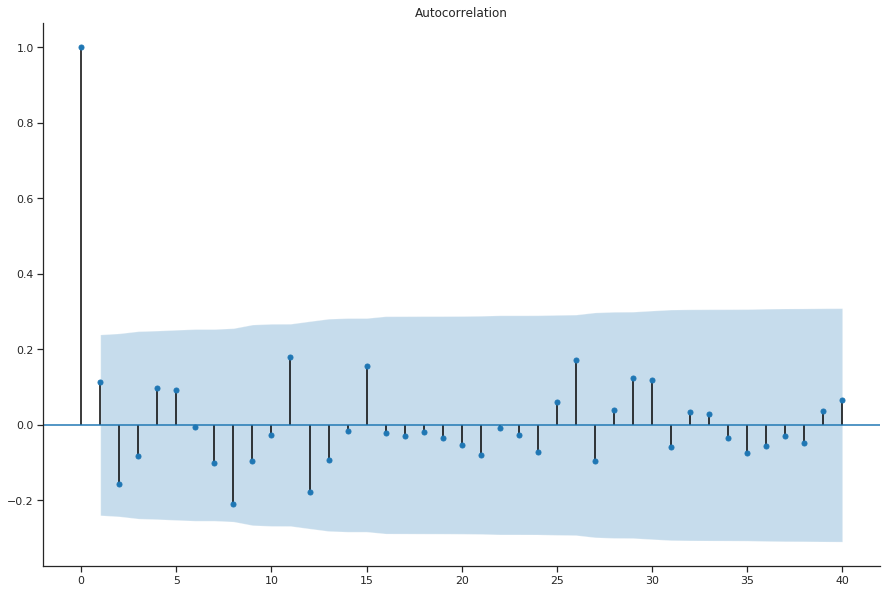

In [109]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

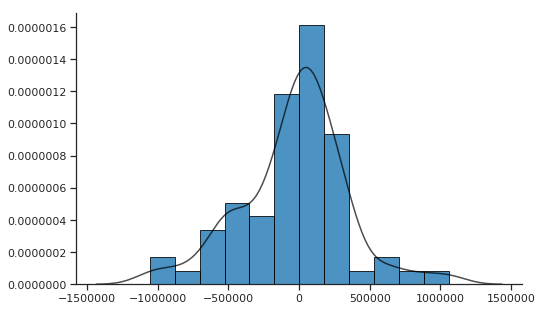

In [110]:
from plotting import histogram

histogram(resid)
plt.show()


## Validaci&oacute;n del Modelo

Vamos a comparar adem&aacute;s graficamente Holt Winter multiplicativo, aditivo y Random walk. 


In [114]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2018-08', 'M')

In [116]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal Random Walk', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

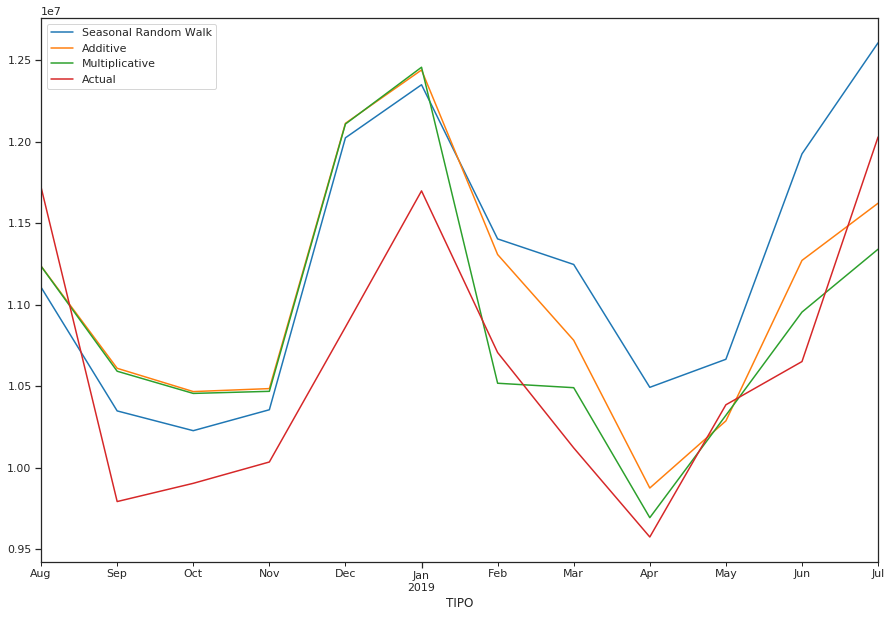

In [117]:
results.plot();

In [118]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal Random Walk,779964.344,148054.667
Additive,644563.980,147906.392
Multiplicative,595282.605,161024.608


## Prediccion

Finalmente generamos un pronostico de dos años basado en el modelo seleccionado.

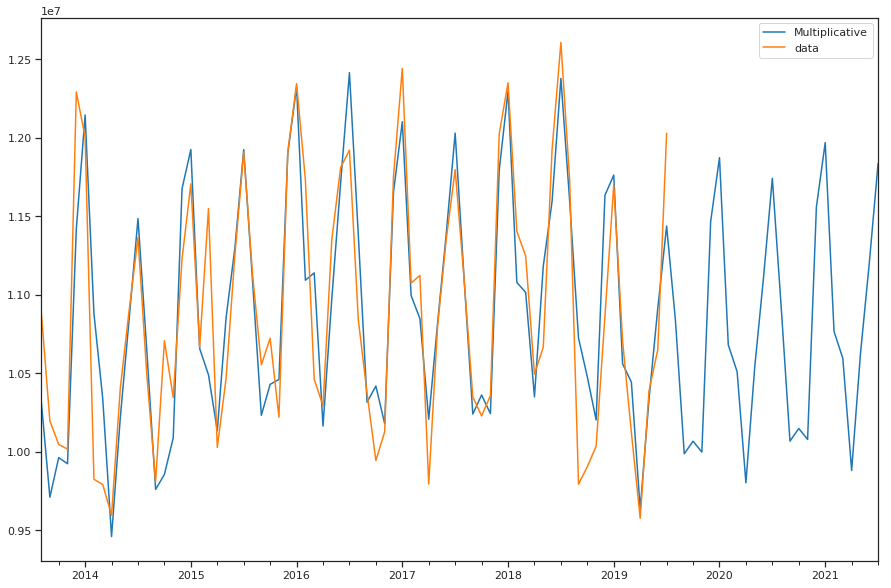

In [119]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['data'] = y

plot[-(w+h):].plot();#figsize=(9,6))